## Machine Learning: Regression

Regression is a class of ML algorithms that predict some numeric value.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.linear_model
import sklearn.compose
import sklearn.tree

As an example let's consider a dataset that predicts prices of railway tickets between European cities:

In [4]:
df = pd.read_csv("../../data/renfe-rail-sample.zip",compression='zip')
df

,Unnamed: 0,id,company,origin,destination,departure,arrival,duration,vehicle_type,vehicle_class,price,fare,seats,departure_hour,geodistance
0,37402744,37402745,renfe,MADRID,BARCELONA,2020-09-28,2020-09-28,2.83,AVE,Turista,108.90,Flexible,232.0,18,506.741151
1,37402745,37402746,renfe,MADRID,BARCELONA,2020-09-28,2020-09-28,2.50,AVE,Turista Plus,115.65,Promo +,40.0,19,506.741151
2,37402746,37402747,renfe,MADRID,BARCELONA,2020-09-28,2020-09-28,3.17,AVE,Turista,108.90,Flexible,177.0,20,506.741151
3,37402747,37402748,renfe,MADRID,BARCELONA,2020-10-10,2020-10-10,3.17,AVE,Turista,108.90,Flexible,279.0,7,506.741151
4,37402748,37402749,renfe,MADRID,BARCELONA,2020-10-10,2020-10-10,3.07,AVE,Turista,108.90,Flexible,238.0,9,506.741151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1246671,38753055,38753056,renfe,ZARAGOZA,BARCELONA,2020-10-08,2020-10-08,1.85,AVE,Turista Plus,54.75,Promo +,15.0,18,256.506445
1246672,38753056,38753057,renfe,ZARAGOZA,BARCELONA,2020-10-08,2020-10-08,1.80,AVE,Turista,60.90,Flexible,215.0,18,256.506445
1246673,38753057,38753058,renfe,ZARAGOZA,BARCELONA,2020-10-08,2020-10-08,2.12,ALVIA,Turista,53.60,Flexible,20.0,19,256.506445
1246674,38753058,38753059,renfe,ZARAGOZA,BARCELONA,2020-10-08,2020-10-08,1.57,AVE,Turista,60.90,Flexible,29.0,19,256.506445


Let's split the dataset between training set and test set (or validation set):

In [5]:
df_train, df_test = sk.model_selection.train_test_split(df,train_size=0.2)

To begin with, let's predict the price using only one parameter - distance between cities. Let's visualize it:

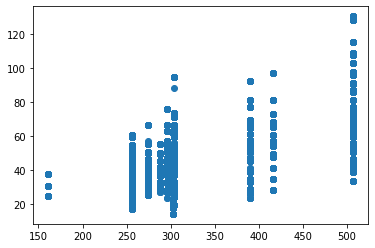

In [6]:
X = df_train["geodistance"]
Y = df_train["price"]
plt.scatter(X,Y)
plt.show()

### Linear Regression 

Linear regression is a simplest model, in which predictive function is linear: $f_{a,b}(x) = ax+b$. Here $a$ and $b$ are model parameters, which we need to find in order to train the model.

We can take **mean square error** as a measure of how well our model performs. In this case, **model loss** will be given by

$$
L(a,b) = \sum_i (f_{a,b}(x_i)-y_i)^2 = \sum_i (ax_i+b-y_i)^2
$$

To find the minimum, let's make a derivative equal to 0:

$$
\begin{cases}
{\partial L\over\partial b} = \sum_i 2(ax_i+b-y_i) = 0 \cr
{\partial L\over\partial a} = \sum_i 2(ax_i+b-y_i)x_i = 0
\end{cases}
$$

From the equations above:
$$
\begin{cases}
a\sum x_i + nb  = \sum y_i \\
a\sum x_i^2 + b\sum x_i = \sum x_iy_i
\end{cases}
$$

Solving this with respect to $a$ and $b$, we get:
$$
\begin{cases}
a = {\sum x_i\sum y_i - n\sum x_iy_i \over (\sum x_i)^2 - n\sum x_i^2} \\
b = {\sum y_i\sum x_i^2 - \sum x_i\sum x_iy_i \over \sum x_i^2(n - \sum x_i) }
\end{cases}
$$

This approach to analytic solution is called **method of least squares**.

In [ ]:
n = len(X)
a = (X.sum()*Y.sum()-n*(X*Y).sum())/(X.sum()*X.sum()-n*(X*X).sum())
b = (Y.sum()*(X*X).sum()-X.sum()*(X*Y).sum())/(X*X).sum()/(n-X.sum())
print(f"a={a}, b={b}")

In [ ]:
plt.scatter(X,Y)
lX = [X.min(),X.max()]
lY = [a*x+b for x in lX]
plt.plot(lX,lY,c='red')
plt.show()

Let's compute the error on our test set:

In [ ]:
X_t, Y_t = df_test["geodistance"], df_test["price"]

def MSE(x,y):
    return np.mean(np.square(x-y)) 

def MAE(x,y):
    return np.mean(np.abs(x-y))

print(f"MSE={np.sqrt(MSE(a*X_t+b,Y_t))}, MAE={MAE(a*X_t+b,Y_t)}, MAE(%)={MAE(a*X_t+b,Y_t)/Y_t.mean()}")

We can now predict the price with an error of 28%.

### Gradient Descent Optimization

Least squares can be used for any number of input variables. However, for large number it becomes too computationally challenging, thus another technique is used to find approximate solution, called **gradient descent optimization**.

It goes as follows: first, we set parameters to some random initial values $a_0, b_0$. Then, at each step of optimization, we compute loss on the dataset (either on the whole dataset, or on some subset of it which is called **minibatch** - in this case optimization is called **stochastic gradient descent**, SGD), and then adjust weights in the following manner:
$$\begin{cases}
a^{(i+1)} = a^{(i)} - \eta{\partial L\over\partial a} \\
b^{(i+1)} = b^{(i)} - \eta{\partial L\over\partial b} \\
\end{cases}$$

Here $\eta$ is some relatively small value called **learning rate**.

Using mean squared error (MSE) as loss:
$$
MSE = {1\over n}\sum_i(aX_i+b-Y_i)^2
$$
we can manually compute the derivatives:
$$\begin{cases}
{\partial L\over\partial a} = {2\over n} \sum_i (aX_i+b-Y_i)*X_i \\
{\partial L\over\partial b} = {2\over n} \sum_i (aX_i+b-Y_i)
\end{cases}$$

In [ ]:
a,b = np.random.normal(size=2)
eta = 0.000005
for i in range(10):
    print(f"Epoch {i}: MSE={MSE(a*X+b,Y)}")
    # print(f"a={a},b={b}")
    a,b = a-eta*((a*X+b-Y)*X).mean(), b-eta*(a*X+b-Y).mean()

Let's see the result:

In [ ]:
print(f"MSE={MSE(a*X_t+b,Y_t)}, MAE={MAE(a*X_t+b,Y_t)}, MAE(%)={MAE(a*X_t+b,Y_t)/Y_t.mean()}")
plt.scatter(X,Y)
lX = [X.min(),X.max()]
lY = [a*x+b for x in lX]
plt.plot(lX,lY,c='red')
plt.show()

As we can see, the result is almost the same as in the least squares method. 

> **IMPORTANT**: Success of the method largely depends on the selection of $\eta$ parameter. Try to increase or decrease $\eta$ by an order of magnitude and see what happens.

### Adding Features

Let's add some more numeric features:

In [ ]:
X = df_train[["geodistance","duration","departure_hour"]]
X_t = df_test[["geodistance","duration","departure_hour"]]

*a, b = np.random.normal(size=4)
a = np.array(a)
eta = 0.000005
for i in range(10):
    print(f"Epoch {i}: MSE={MSE(X@a+b,Y)}")
    # print(f"a={a},b={b}")
    a,b = a-eta*((X@a+b-Y)*X.T).mean(axis=1), b-eta*(X@a+b-Y).mean()

In [ ]:
a,b

In [ ]:
np.mean(np.abs(X_t@a+b-Y_t))

### Categorical Features

Most probably, such features as **class** or **fare** play an important role in the price prediction.

In [7]:
df["fare"].value_counts()

Promo +       566980
Flexible      422474
Adulto ida    257222
Name: fare, dtype: int64

Let's plot the average price depending on the fare:

In [ ]:
df.groupby('fare').mean()['price'].plot(kind='bar')

Categorical features can be of two types:

* **Nominal**, when feature values are just distinct values with no specific order. For example, color, or city name
* **Ordinal**, when feature value somehow reflect the magnitude of the underlying concept. For example, grades (A, B, F-, etc.), or attitude indicators (Very negative/negative/neutral/positive/very positive).

Depending on the feature type, we can use different encoding techniques:
* **Label Encoding**, where each value is encoded by some numeric value. This approach is good for **ordinal** features. For example, we can replace grades by a number from 0 to 7. This should not be used for nominal features, because it introduces additional relation into the data, which is not originally there.
* **One-Hot Encoding** is better suited for **nominal** features, where for each feature value we introduce separate column containing 0 and 1. In other words, we encode feature value by a 0-1 vector, where 1 is placed the position according to the feature value, eg. red color can be represented by (1,0,0,0,0,0,0), and green - by (0,0,0,1,0,0,0).
* There are also other encoding technique described [in this blog post](https://habr.com/ru/post/666234/)

In our case, it is not completely obvious which approach to use. Taking into account the chart above, fares can probably be places in this order of increasing price: Adulto, Promo+, Flexible - and thus can be encoded by numbers 0, 1 and 2 respectively.

Or, we can use one-hot encoding and make no assumptions on relative prices of different fares. In `pandas` we can use `get_dummies` function to make one-hot encoding:

In [8]:
pd.get_dummies(df["fare"])

,Adulto ida,Flexible,Promo +
0,0,1,0
1,0,0,1
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
1246671,0,0,1
1246672,0,1,0
1246673,0,1,0
1246674,0,1,0


In [ ]:
X = pd.get_dummies(df_train,columns=["fare"])[['price','fare_Adulto ida','fare_Promo +','fare_Flexible']]
X

In [ ]:
*a, b = np.random.normal(size=5)
a = np.array(a)
eta = 0.0001
for i in range(10):
    print(f"Epoch {i}: MSE={MSE(X@a+b,Y)}")
    # print(f"a={a},b={b}")
    a,b = a-eta*((X@a+b-Y)*X.T).mean(axis=1), b-eta*(X@a+b-Y).mean()

We can see that by using additional columns we can significantly improve the accuracy of our model. This is because those additional features contain important information about the ticket which we now take into account.

In linear regression, we can look at the coefficients of the model corresponding to different features, which makes our model **interpretable**:

In [ ]:
a

## Scikit Learn

Instead of programming gradient descent by hand, we can use an existing library to apply regression algorithm to our data. De facto standard in Machine Learning is a library called [Scikit Learn](https://scikit-learn.org/stable/index.html). 

Let's implement linear regression using Scikit Learn. To begin with, let's list all numerical and categorical features:

In [9]:
numeric = ['geodistance','duration','departure_hour']
categorical = ['vehicle_type','vehicle_class','fare']

To train our regression only on numerical features, we can use this simple code:

In [12]:
X = df_train[numeric]
model = sk.linear_model.LinearRegression()
model = model.fit(X,Y)

The main method to train the model is called `fit`. It is because finding the best parameters to minimize loss is called *fitting the model*.

Let's compute error on test data:

In [13]:
X_t = df_test[numeric]
Y_t_pred = model.predict(X_t)
print(f"MSE={sk.metrics.mean_squared_error(Y_t,Y_t_pred)}, \
MAE={sk.metrics.mean_absolute_error(Y_t,Y_t_pred)}, \
MAE(%)={sk.metrics.mean_absolute_percentage_error(Y_t,Y_t_pred)}")

NameError: name 'Y_t' is not defined

Let's look at the model's coefficients:

In [ ]:
print(f"Coefficients={model.coef_}, bias={model.intercept_}")

To encode categorical features, we can also use Scikit Learn mechanisms. Objects to do the encoding are called **Encoders**. That's how we can use encoders:

In [14]:
ohe = sk.preprocessing.OneHotEncoder()
ohe.fit(df[["fare","vehicle_class"]])
print(ohe.categories_)
ohe.transform(df[["fare","vehicle_class"]]).toarray()[:10]

[array(['Adulto ida', 'Flexible', 'Promo +'], dtype=object), array(['Turista', 'Turista Plus', 'Turista con enlace'], dtype=object)]


array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 1., 0., 0.],
       [0., 0., 1., 1., 0., 0.]])

To apply different encoders to different colums, we can use another abstraction called **transformer**. We can obtain the encoded table in one go, specifying encoders for all categorical features, and making all other columns pass through unchanged:

In [ ]:
transformer = sk.compose.make_column_transformer(
    (sk.preprocessing.OneHotEncoder(),['fare']),
    (sk.preprocessing.OneHotEncoder(),['vehicle_type']),
    (sk.preprocessing.OneHotEncoder(),['vehicle_class']),
    remainder='passthrough'
)
X = transformer.fit_transform(df_train[numeric+categorical])
X.toarray()[:2]

Obtained values can be used to train the model:

In [ ]:
model = sk.linear_model.LinearRegression()
model = model.fit(X,Y)
X_t = transformer.transform(df_test[numeric+categorical])
Y_t_pred = model.predict(X_t)
print(f"MSE={sk.metrics.mean_squared_error(Y_t,Y_t_pred)}, \
MAE={sk.metrics.mean_absolute_error(Y_t,Y_t_pred)}, \
MAE(%)={sk.metrics.mean_absolute_percentage_error(Y_t,Y_t_pred)}")

### Adding Attributes

Sometimes, the result are not a linear function of features. For example, when computing the remaining amount of money on a bank account which follows compound interest are likely to follow exponential relationship from time. In this case we can improve the quality of the model by replacing the value by a logarithm.

In the same manner, we can try to improve the accuracy of a linear model by adding to the original dataset some functions of features or their combinations, which become new features for an extended linear model. 

One of the approaches to do it automatically is to add **polynomial combinations** of features. For example, if original dataset contain features $x_1, x_2, x_3$, then adding all second-order polynomial features we get $x_1^2, x_2^2, x_3^2, x_1x_2, x_1x_3, x_2x_3$, in addition to original features.

This can also be done using a transformer:

In [ ]:
poly = sk.preprocessing.PolynomialFeatures()
Xp = poly.fit_transform(X)
X.shape,Xp.shape

From 24 features we obtained 325 features! Now let's train the model:

In [ ]:
model.fit(Xp,Y)

Xp_t = poly.transform(X_t)
Yp_t_pred = model.predict(Xp_t)
print(f"MSE={sk.metrics.mean_squared_error(Y_t,Yp_t_pred)}, \
MAE={sk.metrics.mean_absolute_error(Y_t,Yp_t_pred)}, \
MAE(%)={sk.metrics.mean_absolute_percentage_error(Y_t,Yp_t_pred)}")

### Using Pipelines

In our example we have used `ColumnTransformer` to encode non-numeric features, then `PolynomialFeatures` to add additional features, and then fed the result into `LinearRegression` object to train the model.

We can bundle those steps into a single **pipeline**, because all steps of this pipeline follow similar interface of having `fit` or `fit_transform` methods:

In [ ]:
pipe = sk.pipeline.Pipeline([
    ('ColumnTransform',transformer),
    ('PolyFeatures',poly),
    ('LinearModel',model)
])
pipe.fit(df_train[numeric+categorical],Y)
pipe.score(df_test[numeric+categorical],Y_t)

Using just a few lines of code we have built a data processing pipeline that pre-processes the data, computed additional features, trains the model and checks it for accuracy.

### Decision Trees

In our case, prices for tickets can change non-linearly, because each fare can have it's own price principles and rules. For such cases, we can use another ML algorithm - **decision trees**. A decision tree looks at some feature, and depending on its value considers several possible ways to compute the result. Then, at each of the sub-trees, we select next feature to look at, and so on.

Let's train the decision tree on our data:

In [ ]:
model = sk.tree.DecisionTreeRegressor()
model = model.fit(X,Y)

Y_t_pred = model.predict(X_t)
print(f"MSE={sk.metrics.mean_squared_error(Y_t,Y_t_pred)}, \
MAE={sk.metrics.mean_absolute_error(Y_t,Y_t_pred)}, \
MAE(%)={sk.metrics.mean_absolute_percentage_error(Y_t,Y_t_pred)}")

Interestingly enough, decision trees give us fantastic accuracy! This is mostly due to the fact that we have just a few combinations of cities in our dataset, and the tree is likely to *remember* typical prices for tickts between those cities in different fares.

Trees are also interpretable, however, it gets hardly interpretable when it grows too big. For clarity, let's limit the depth of the tree - this will decrease accuracy, but will make the tree more observable:

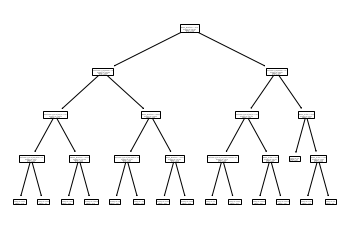

In [32]:
model = sk.tree.DecisionTreeRegressor(max_depth=4)
model = model.fit(X,Y)

z = sk.tree.plot_tree(model,feature_names=transformer.get_feature_names_out())

To get better visualization, we can use **GraphViz** library. It should be installed using `conda install python-graphviz` into your Python environment.

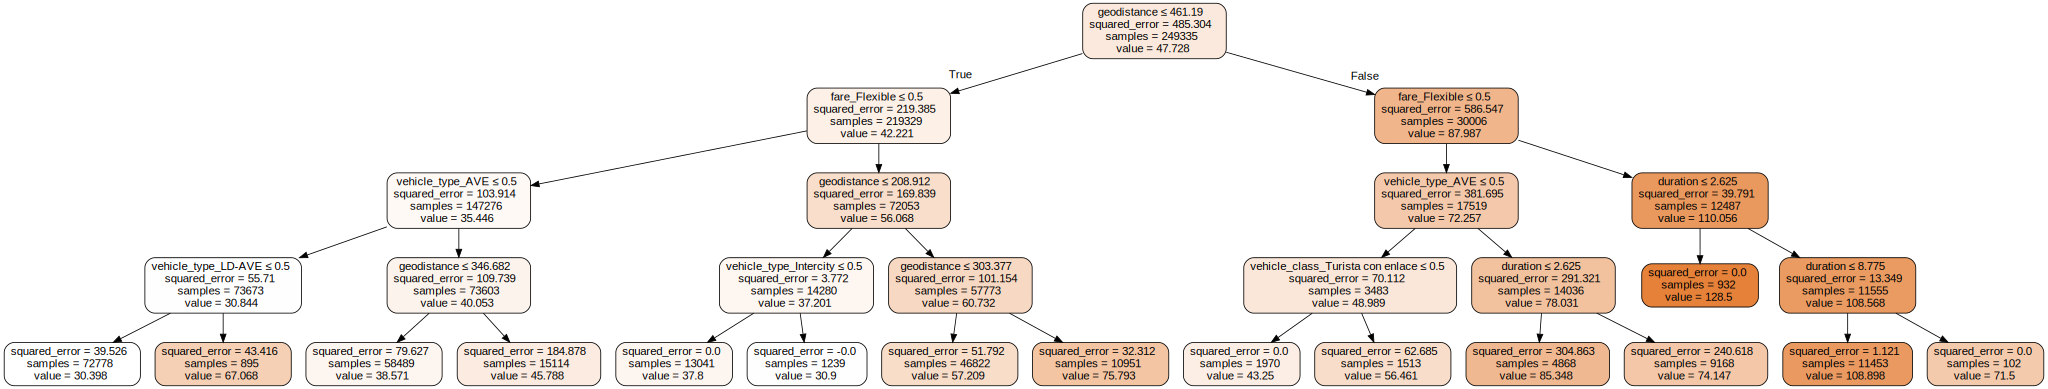

In [33]:
import graphviz
graphviz.backend.dot_command.DOT_BINARY = 'c:/winapp/conda/Library/bin/graphviz/dot.exe'

def proc_feature_name(x):
    return x.replace('onehotencoder-1__','')\
        .replace('onehotencoder-2__','')\
        .replace('onehotencoder-3__','')\
        .replace('remainder__','')

feature_names = [proc_feature_name(x) for x in transformer.get_feature_names_out()]

graphviz.Source(
    sk.tree.export_graphviz(model,feature_names=feature_names,
    filled=True, rounded=True, special_characters=True)
)